<a href="https://colab.research.google.com/github/Gabriel325896/Analisis-Numerico/blob/main/Despacho_PSO_DemandaFija_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Despacho electrico

**Despacho Energia Electrica:**

Cuando se habla de sistemas de energía eléctrica, comúnmente se muestran esquemas simplificados donde un sistema generador envía energía a una carga eléctrica a través de un sistema de transmisión; no lejos de la realidad, este sistema esconde el proceso por el cual se mueve económicamente la energía eléctrica, un sistema más complejo donde todos los entes en la cadena están relacionados.

A este proceso economico se lo conoce como despacho de energia electrica.

El despacho es la programación de la generación para cubrir la demanda esperada, de tal forma que para cada hora se utilicen los recursos de menor precio, cumpliendo con las condiciones límites que tiene el sistema como son las inflexibilidades y las restricciones.


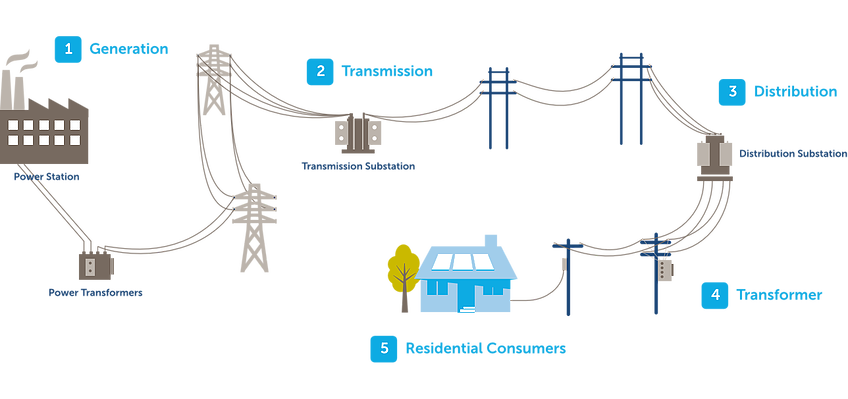

## Librerias utilizadas


In [1]:
# Librerias:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

# Modelo Matematico

$$ min. \; \sum_{i = 1}^{n_{g}} c_{i}P^{2}_{it} + b_iP_{it} + a_{i} \; , \; t = 1,2,...,24
$$   
Sujeto a:
$$\sum_{i = 1}^{n_{g}}P_{it} = PD_{t}  \; , \; t = 1,2,...,24$$


$$Pmin_{i} \leq P_{it} \leq Pmax_{i} \; , \; t = 1,2,...,24$$



# Perfil de Demanda

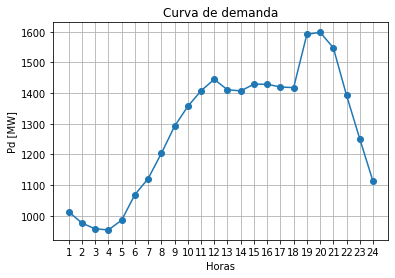

In [3]:
df= [1013.506, 976.565, 957.746, 954.244, 985.864, 1068.756, 
     1121.099, 1203.345, 1291.66, 1356.6, 1407.396, 1444.813,
     1410.796, 1407.26, 1429.003, 1428.884, 1419.857, 1417.885,
     1591.081, 1598.272, 1547.629, 1392.487, 1250.486, 1112.306]
     
x=range(1,25)
plt.plot(x,df,'-o',label='Demanda real')
plt.xticks(np.arange(1, 25, 1))
plt.grid()
plt.title('Curva de demanda')
plt.xlabel('Horas')
plt.ylabel('Pd [MW]')
plt.show()

# Funcion de costos

## Diagrama de flujo Función de Costos

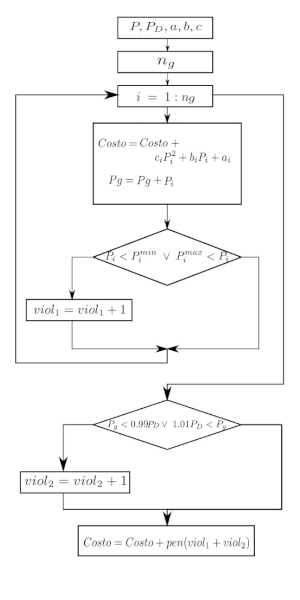

## Código

In [4]:
# Funcion objetivo (minimizar)
def fmin(P,PD,a,b,c,Pb):
  pen =  1000000000000
  ng = len(P) #Número de Generadores
  np = len(P[0]) #Numero de particulas
  costos = [] 
  for j in range(0,np):
    costo = 0
    Pg = 0  
    viol_1 = 0
    for i in range(0,ng):
      costo = c[i]*((P[i][j])**2) + b[i]*P[i][j] + a[i] + costo ##Función de Costos
      Pg = P[i][j] + Pg
      if P[i][j] < Pb[i][0] or Pb[i][1] < P[i][j]:
          viol_1 = viol_1 + 1
    if  Pg < 0.99*PD or Pg > 1.01*PD:
      viol_2 = 1
    else:
      viol_2 = 0
    costo = costo + pen*(viol_2 + viol_1)
    costos.append(costo)
  return costos

# P.S.O. para despacho



Pasos para el metodo de PSO

$$v_{id}= v_{id}+c1*rand()*(p_{id}-x_{id}) +c_2*rand()(p_{gd}-x_{id}) \; \; \;(1)$$

$$x_{id}= x_{id}+v_{id} \; \; \; (2)$$

1° Inicializar una población con posiciones y velocidades aleatorias en d dimensiones dadas por el problema.

2° Para cada partícula evaluar la optimización deseada de la función fitness en d variables.

3° Compare la evaluación de la función con el mejor punto de la misma, pbest. Si el nuevo valor es mejor que el pbest, ese pbset será el nuevo valor.

4° Cambiar la velocidad y la posición de la partícula de acuerdo con las ecuaciones 1 y 2.

5° Repetir desde el ítem 2) teniendo en cuenta un criterio de parada suficientemente bueno o considerando un número máximo de iteraciones.

## Diagrama de flujo PSO

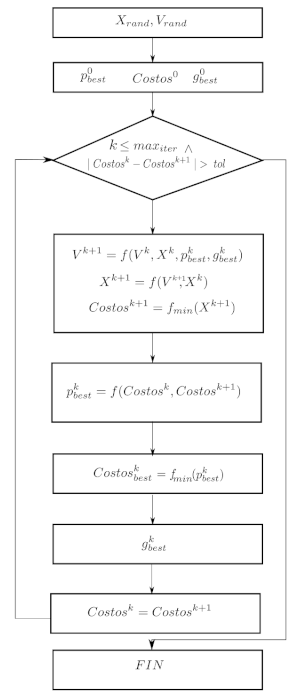

## Código Implementación PSO

In [5]:
def ejecutar_despacho(PD,hh):
    # Pmin - Pmax
    P1b = [10,500] # MW
    P2b = [12,365] # MW
    P3b = [50,720] # MW
    P4b = [20,631] # MW
    Pb = [P1b, P2b, P3b, P4b]
    ## Coeficientes de funcion de costos
    a = [64.67, 65.46, 22.92, 51.]
    b = [795.5, 1448.6, 838.1, 190.92]
    c = [1.15, 0.82, 1.53, 2.46]
    # Incializar particulas
    n_particles = 500# 3000 antes
    min = 0
    max = 700
    nng = len(a)
    X = np.random.rand(nng, n_particles) * (max - min) + min #Posición aleatoria de Particulas
    V = np.random.randn(nng, n_particles) * 0.01 #Velocidad aleatoria inicial de Particulas
    # Pbest y Gbest -> Inicial:
    pbest = X 
    f_0 = np.array(fmin(X,PD,a,b,c,Pb)) 
    min_v = f_0.min() # encontrar el minimo valor
    ind_min = np.where(f_0 == min_v)[0][0]
    gbest = X[:,ind_min] # coordenada para g best en el plano
    #Hiperparametros
    c1 = 0.1
    c2 = 0.3
    w = 0.002
    n = 5000 # cant. max de iteraciones
    j = 1 #contador que inicia en 0
    Conv_t = []
    while True:
        r = np.random.rand(2) # [r1 r2] 
        r1 = r[0] ; r2 = r[1] 
        V = w*V + c1*r1*(pbest - X) + c2*r2*(gbest.reshape(-1,1) - X) #Función de actualización de velocidad de PSO
        X = X + V
        f_k = np.array(fmin(X,PD,a,b,c,Pb))
        for i in range(0,n_particles):
            if f_k[i] < f_0[i]:
                pbest[:,i] = X[:,i]
        f_gbest = np.array(fmin(pbest,PD,a,b,c,Pb))
        min_ant = min_v
        Conv_t.append(min_ant)
        min_v = f_gbest.min() # encontrar el minimo
        ind_min = np.where(f_gbest == min_v)[0][0] # el lugar donde esta el minimo
        gbest = pbest[:,ind_min] # coordenada para g best
        f_0 = f_k 
        j = j + 1
        if j >= n or abs(min_v - min_ant) < 1e-9:
            Conv_t.append(min_v)
            break
    plt.plot(Conv_t, 'o-')
    plt.xticks(np.arange(0, len(Conv_t), 1))
    plt.grid()
    plt.title('Funcion de costo en hora ' + str(hh) )
    plt.xlabel('Iteraciones')
    plt.ylabel('Costo [$]')
    plt.show()
    return gbest

# Resultados



## Diagrama de Flujo Resultados

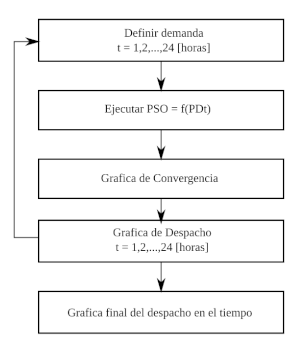

##Código Resultados

1013.506


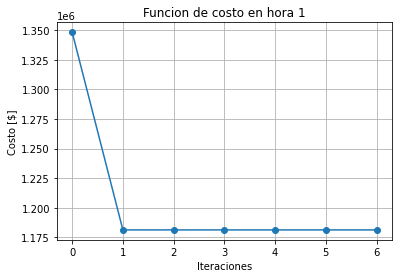

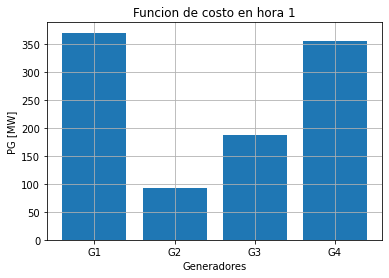

1004.6188810859984
976.565


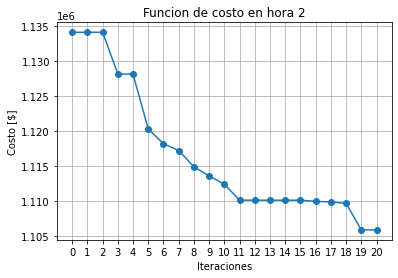

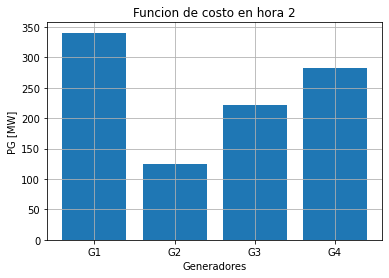

967.3956592167954
957.746


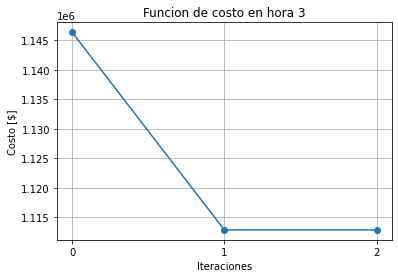

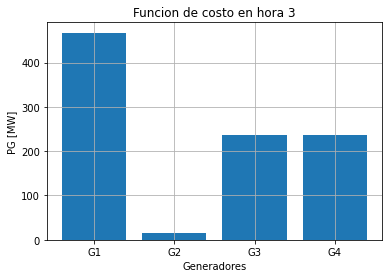

956.2426050980325
954.244


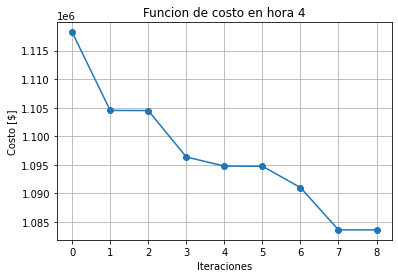

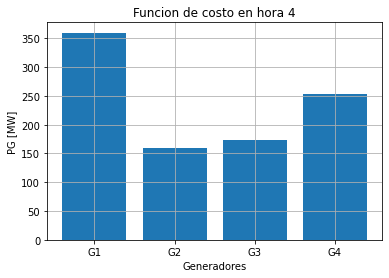

945.19996340199
985.864


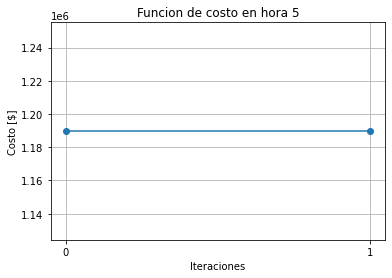

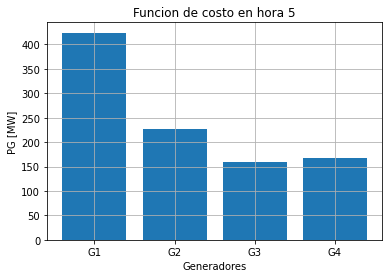

978.8143288996081
1068.756


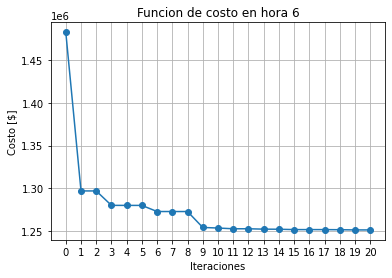

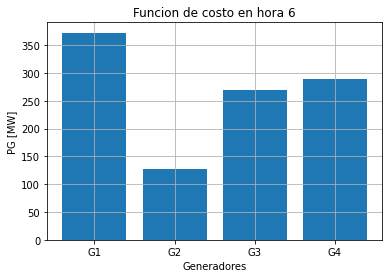

1058.0830478516657
1121.099


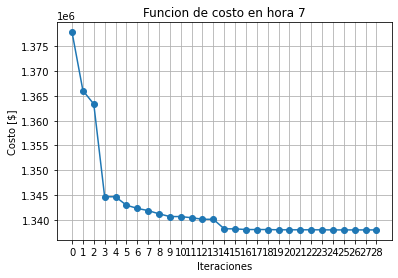

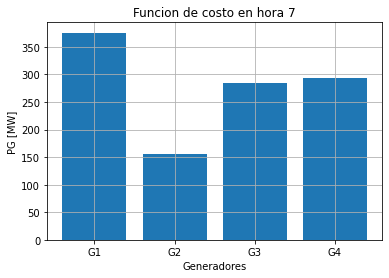

1109.9115794988204
1203.345


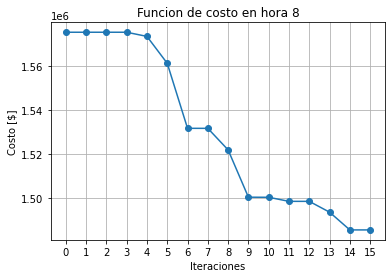

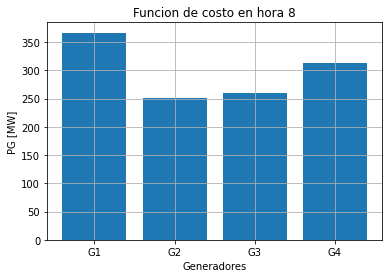

1191.5131534099319
1291.66


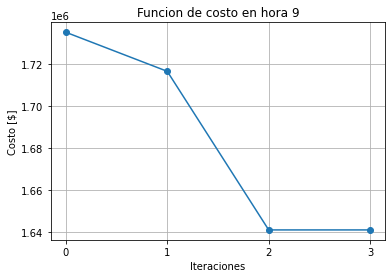

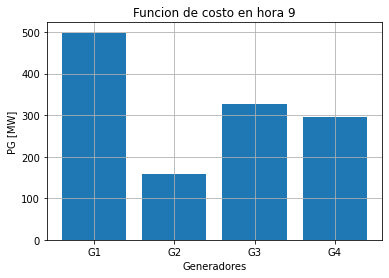

1279.0645894918425
1356.6


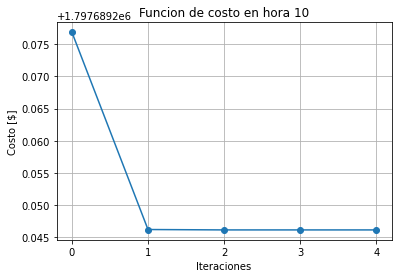

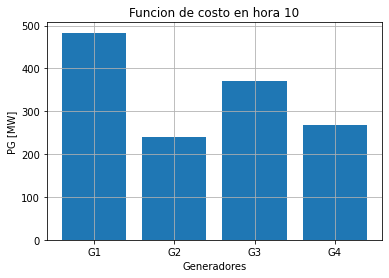

1362.2251354523376
1407.396


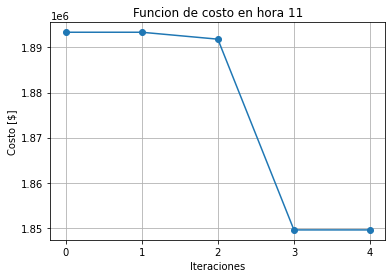

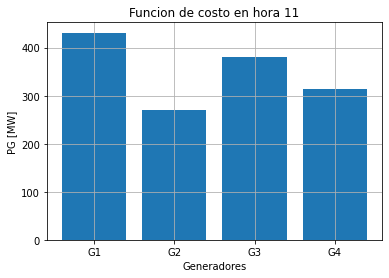

1394.8773233982379
1444.813


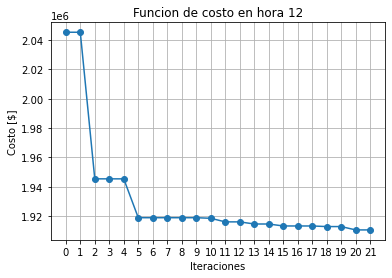

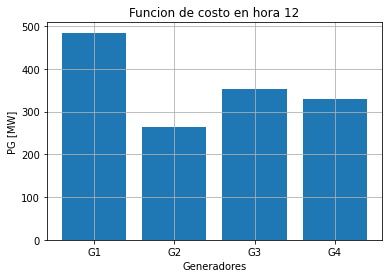

1430.4570918692161
1410.796


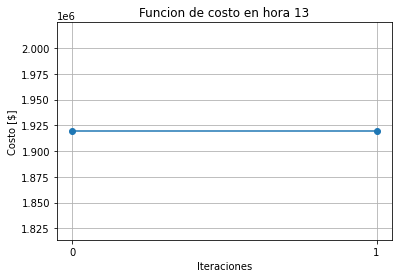

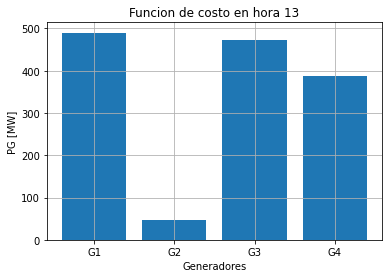

1397.9057516039113
1407.26


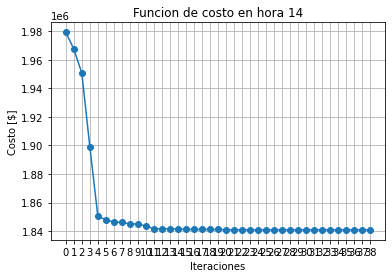

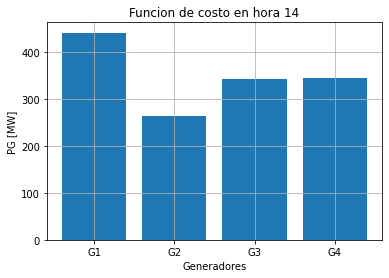

1393.1894651860207
1429.003


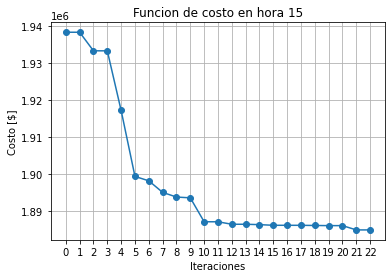

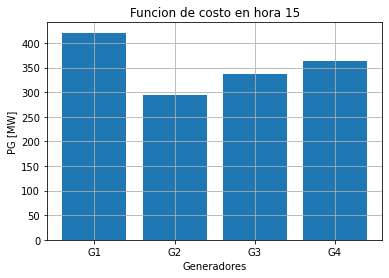

1414.7517605499802
1428.884


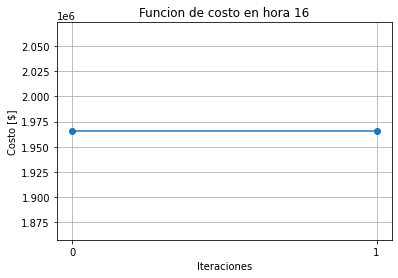

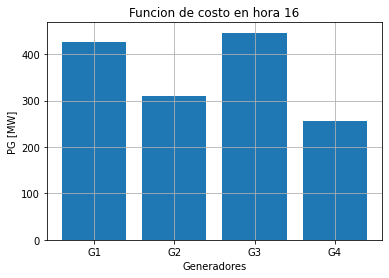

1439.0680885068055
1419.857


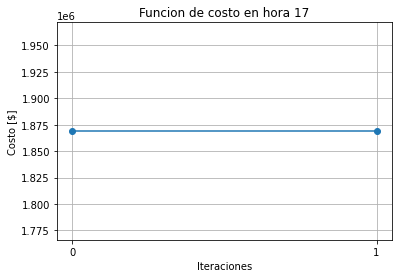

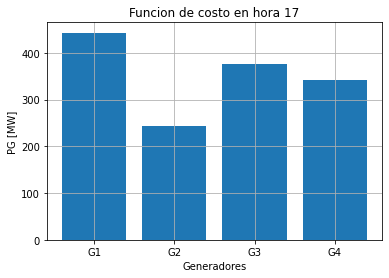

1407.0568282237969
1417.885


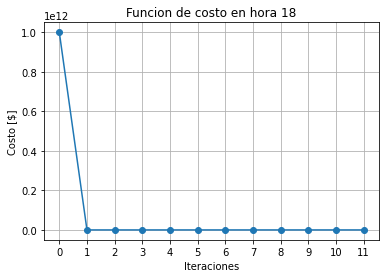

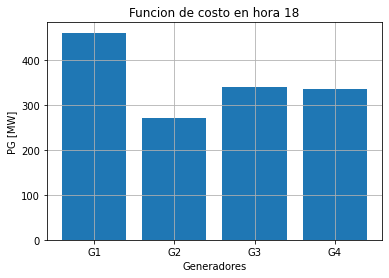

1403.86788636428
1591.081


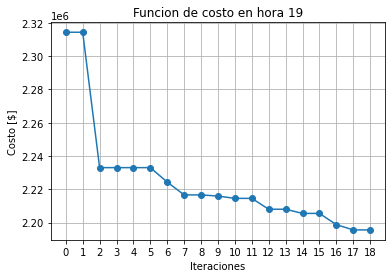

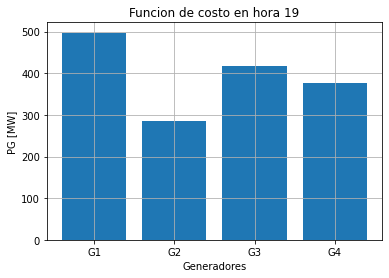

1575.673248330298
1598.272


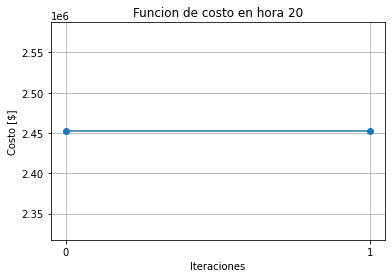

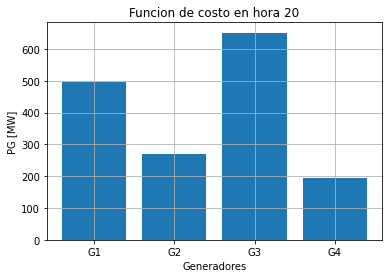

1611.2299066416508
1547.629


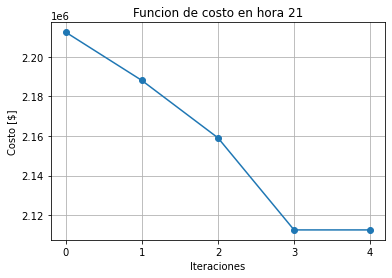

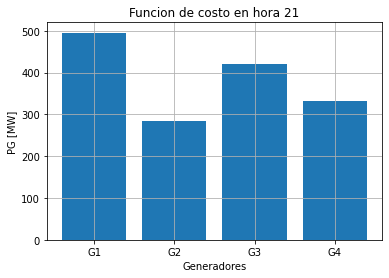

1532.3996900955633
1392.487


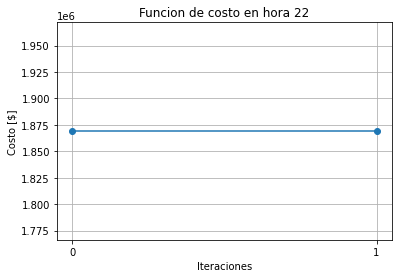

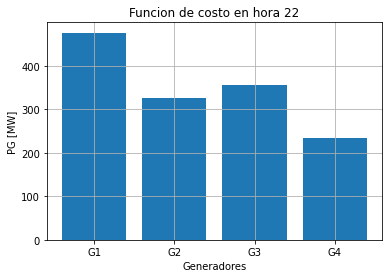

1391.0968944521005
1250.486


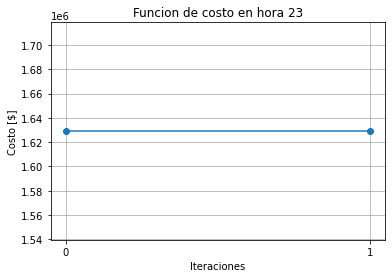

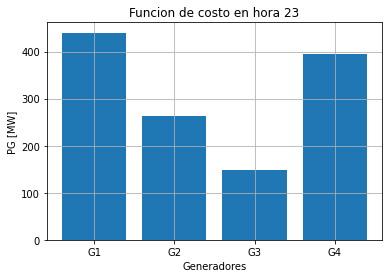

1246.7966966443216
1112.306


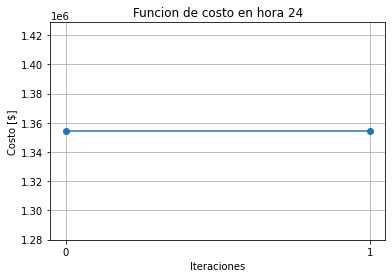

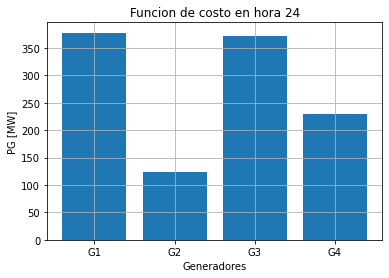

1103.7993231939738
[1004.6188810859984, 967.3956592167954, 956.2426050980325, 945.19996340199, 978.8143288996081, 1058.0830478516657, 1109.9115794988204, 1191.5131534099319, 1279.0645894918425, 1362.2251354523376, 1394.8773233982379, 1430.4570918692161, 1397.9057516039113, 1393.1894651860207, 1414.7517605499802, 1439.0680885068055, 1407.0568282237969, 1403.86788636428, 1575.673248330298, 1611.2299066416508, 1532.3996900955633, 1391.0968944521005, 1246.7966966443216, 1103.7993231939738]


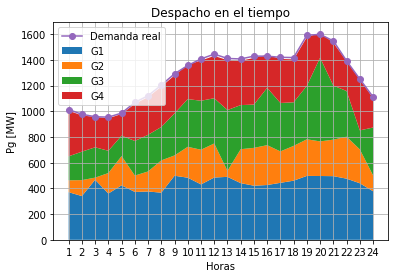

In [6]:
nd = len(df)
Gen_t = []
Val_gen = []
G = []
ng = 4


for i in range(ng):
  G.append([])

for i in range(nd):
    demanda_i = df[i]
    print(demanda_i)
    Xgen = ejecutar_despacho(demanda_i,i+1)
    Plot_bar = []
    for j in range(ng):
        G[j].append(Xgen[j])
        Plot_bar.append('G'+str(j+1))
    plt.bar(Plot_bar,Xgen)
    plt.title('Funcion de costo en hora ' + str(i+1))
    plt.xlabel('Generadores')
    plt.ylabel('PG [MW]')
    plt.grid()
    plt.show()
    Gen_t.append(Xgen)
    Val_gen.append(sum(Xgen))
    print(sum(Xgen))

print(Val_gen)


plt.stackplot(x,G,labels=Plot_bar)
plt.plot(x, df,'-o',label='Demanda real')
plt.legend(loc='upper left')
plt.xticks(np.arange(1, 25, 1))
plt.grid()
plt.title('Despacho en el tiempo')
plt.xlabel('Horas')
plt.ylabel('Pg [MW]')
plt.show()
